In [1]:
# Stop warnings
import warnings
warnings.filterwarnings("ignore")

# Imports
import os
import cv2
import sys
import time
import json
import copy
import cortex
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt


# Personal imports
sys.path.append("{}/../../../analysis_code/utils".format(os.getcwd()))
from plot_utils import *
from pycortex_utils import draw_cortex, set_pycortex_config_file, load_surface_pycortex, create_colormap, get_rois
from surface_utils import load_surface

In [2]:
# Directories
main_dir = '/Users/uriel/disks/meso_shared'
project_dir = 'RetinoMaps'

In [3]:
with open('../../settings.json') as f:
    json_s = f.read()
    analysis_info = json.loads(json_s)

In [4]:
# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Webgl port
port_num = 25000

# pRF

In [53]:
# Settings
subject = 'sub-11'
pycortex_subject = 'sub-170k'
format_ = '170k'
extension = 'dtseries.nii'
suffix = 'Sac_Pur'
flatmaps_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_flatmaps'

In [54]:
prf_task_name = analysis_info['prf_task_name']
maps_names_css = analysis_info['maps_names_css']
maps_names_pcm = analysis_info['maps_names_pcm']
maps_names_css_stats = analysis_info['maps_names_css_stats']



rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']

parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']
save_svg = False
# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
# masks = {'parietal_mask':parietal_mask}
masks = {'parietal_frontal_mask':parietal_frontal_mask}

## Flatmaps

In [55]:
for mask in masks.keys():
    rois_mask = masks[mask]
    all_idx = 0
    # Maps settings 
    for idx, col_name in enumerate(maps_names_css + maps_names_css_stats + maps_names_pcm):
        exec("{}_idx = idx".format(col_name))

    cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
    col_offset = 1.0/14.0
    cmap_steps = 255

    # plot scales
    pcm_scale = [0, 10]
    size_scale = [0, 10]
    ecc_scale = [0, 10]
    rsq_scale = [0, 1]
    n_scale = [0, 2]


    # Define directories and fn
    prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
    prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
    intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(
    main_dir, project_dir, subject,format_)

    # Derivatives
    deriv_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-deriv_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    deriv_results = load_surface_pycortex(brain_fn=deriv_median_fn)
    deriv_mat = deriv_results['data_concat']

    # Stats
    stats_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    stats_results = load_surface_pycortex(brain_fn=stats_median_fn)
    stats_mat = stats_results['data_concat']

    # pRF CM
    pcm_median_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-pcm_css_loo-median.dtseries.nii'.format(
        prf_deriv_dir, subject, prf_task_name)
    pcm_results = load_surface_pycortex(brain_fn=pcm_median_fn)
    pcm_mat = pcm_results['data_concat']

    # intertask results 
    stats_avg_fn = '{}/{}_intertask_{}.dtseries.nii'.format(
    intertask_dir, subject, suffix)
    results_stats = load_surface_pycortex(brain_fn=stats_avg_fn)
    intertask_mat = results_stats['data_concat']
    mask_intertask = intertask_mat[all_idx, :] == 7

    # Combine mat
    all_deriv_mat = np.concatenate((deriv_mat, stats_mat, pcm_mat))

    # Threshold mat
    all_deriv_mat_th = all_deriv_mat
    amp_down = all_deriv_mat_th[amplitude_idx,...] > 0
    rsq_down = all_deriv_mat_th[prf_loo_r2_idx,...] >= analysis_info['rsqr_th']
    size_th_down = all_deriv_mat_th[prf_size_idx,...] >= analysis_info['size_th'][0]
    size_th_up = all_deriv_mat_th[prf_size_idx,...] <= analysis_info['size_th'][1]
    ecc_th_down = all_deriv_mat_th[prf_ecc_idx,...] >= analysis_info['ecc_th'][0]
    ecc_th_up = all_deriv_mat_th[prf_ecc_idx,...] <= analysis_info['ecc_th'][1]
    n_th_down = all_deriv_mat_th[prf_n_idx,...] >= analysis_info['n_th'][0]
    n_th_up = all_deriv_mat_th[prf_n_idx,...] <= analysis_info['n_th'][1]
    if analysis_info['stats_th'] == 0.05: stats_th_down = all_deriv_mat_th[corr_pvalue_5pt_idx,...] <= 0.05
    elif analysis_info['stats_th'] == 0.01: stats_th_down = all_deriv_mat_th[corr_pvalue_1pt_idx,...] <= 0.01
    all_th = np.array((amp_down,
                       rsq_down,
                       size_th_down,size_th_up, 
                       ecc_th_down, ecc_th_up,
                       n_th_down, n_th_up,
                       stats_th_down
                      )) 
    all_deriv_mat[prf_loo_r2_idx, np.logical_and.reduce(all_th)==False]=0 # put this to zero to not plot it

    # Create flatmaps
    maps_names = []

    # Loo r-square and alpha
    loo_rsq_data = all_deriv_mat[prf_loo_r2_idx,...]
    alpha = loo_rsq_data
    alpha_range = analysis_info["alpha_range"]
    alpha = (alpha - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
    alpha[alpha>1]=1

    # put alpha to 0 outside non interest roi 
    alpha[~rois_mask] = 0
    alpha[~mask_intertask] = 0

    # param_loo_rsq = {'data': loo_rsq_data, 
    #                  'cmap': cmap_uni, 
    #                  'alpha': alpha, 
    #                  'vmin': rsq_scale[0], 
    #                  'vmax': rsq_scale[1], 
    #                  'cbar': 'discrete', 
    #                  'cortex_type': 'VertexRGB',
    #                  'description': 'CSS pRF LOO R2',
    #                  'curv_brightness':1,
    #                  'curv_contrast': 0.1,
    #                  'add_roi': save_svg,
    #                  'cbar_label': 'pRF LOO R2', 
    #                  'with_labels': True}
    # maps_names.append('loo_rsq')

#     # Polar angle
#     pol_comp_num = all_deriv_mat[polar_real_idx,...] + 1j * all_deriv_mat[polar_imag_idx,...]
#     polar_ang = np.angle(pol_comp_num)
#     ang_norm = (polar_ang + np.pi) / (np.pi * 2.0)
#     ang_norm = np.fmod(ang_norm + col_offset,1)
#     param_polar = {'data': ang_norm, 
#                    'cmap': cmap_polar, 
#                    'alpha': alpha, 
#                    'vmin': 0, 
#                    'vmax': 1, 
#                    'cmap_steps': cmap_steps, 
#                    'cortex_type': 'VertexRGB',
#                    'cbar': 'polar', 
#                    'col_offset': col_offset, 
#                    'description': 'CSS pRF polar angle', 
#                    'curv_brightness': 0.1, 
#                    'curv_contrast': 0.25, 
#                    'add_roi': save_svg, 
#                    'with_labels': True}
#     exec('param_polar_{cmap_steps} = param_polar'.format(cmap_steps = int(cmap_steps)))
#     exec('maps_names.append("polar_{cmap_steps}")'.format(cmap_steps = int(cmap_steps)))

#     # Eccentricity
#     ecc_data = all_deriv_mat[prf_ecc_idx,...]
#     param_ecc = {'data': ecc_data, 
#                  'cmap': cmap_ecc_size, 
#                  'alpha': alpha,
#                  'vmin': ecc_scale[0], 
#                  'vmax': ecc_scale[1], 
#                  'cbar': 'ecc', 
#                  'cortex_type': 'VertexRGB',
#                  'description': 'CSS pRF eccentricity', 
#                  'curv_brightness': 1,
#                  'curv_contrast': 0.25, 
#                  'add_roi': save_svg, 
#                  'with_labels': True}
#     maps_names.append('ecc')

#     # Size
#     size_data = all_deriv_mat[prf_size_idx,...]
#     param_size = {'data': size_data, 
#                   'cmap': cmap_ecc_size, 
#                   'alpha': alpha, 
#                   'vmin': size_scale[0], 
#                   'vmax': size_scale[1], 
#                   'cbar': 'discrete', 
#                   'cortex_type': 'VertexRGB', 
#                   'description': 'CSS pRF size', 
#                   'curv_brightness': 1, 
#                   'curv_contrast': 0.25, 
#                   'add_roi': False, 
#                   'cbar_label': 'pRF size (dva)',
#                   'with_labels': True}
#     maps_names.append('size')

    # # n
    # n_data = all_deriv_mat[prf_n_idx,...]
    # param_n = {'data': n_data, 
    #            'cmap': cmap_ecc_size, 
    #            'alpha': alpha, 
    #            'vmin': n_scale[0], 
    #            'vmax': n_scale[1], 
    #            'cbar': 'discrete', 
    #            'cortex_type': 'VertexRGB', 
    #            'description': 'CSS pRF n',
    #            'curv_brightness': 1, 
    #            'curv_contrast': 0.1, 
    #            'add_roi': False, 
    #            'cbar_label': 'pRF n',
    #            'with_labels': True}
    # maps_names.append('n')

    # pcm
    pcm_data = all_deriv_mat[pcm_median_idx,...]
    param_pcm = {'data': pcm_data, 
                 'cmap': cmap_ecc_size, 
                 'alpha': alpha, 
                 'vmin': pcm_scale[0], 
                 'vmax': pcm_scale[1], 
                 'cbar': 'discrete', 
                 'cortex_type': 'VertexRGB', 
                 'description': 'CSS pRF CM',
                 'curv_brightness': 1, 
                 'curv_contrast': 0.25, 
                 'add_roi': False, 
                 'cbar_label': 'pRF CM (mm/dva)',
                 'with_labels': True}
    maps_names.append('pcm')

#     maps_names = [element + '_' + mask for element in maps_names]
    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = 'pRF_{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))
        # exec("plt.savefig('{}/{}_task-{}_{}_css_{}.pdf')".format(flatmaps_dir, subject, prf_task_name, maps_name, mask))
        plt.close()

pRF_pcm


## WebGL

In [56]:
port_num = port_num + 1

# data = volume_ecc
# data = volume_size
data = volume_pcm

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=data,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois',),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25002/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25002


In [57]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
# im1 = handle.getImage('{}/inflated_ecc.png'.format(inflated_dir),size = (3000, 3000))
# im1 = handle.getImage('{}/inflated_size.png'.format(inflated_dir),size = (3000, 3000))
im1 = handle.getImage('{}/inflated_pCM.png'.format(inflated_dir),size = (3000, 3000))

# CM video

In [64]:
# Settings
subject = 'sub-03'
pycortex_subject = 'sub-03'
format_ = 'fsnative'
extension = 'func.gii'
suffix = 'Sac_Pur'
save_svg = False
flatmaps_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_flatmaps'

## Load data

In [65]:
prf_task_name = analysis_info['prf_task_name']
maps_names_css = analysis_info['maps_names_css']
maps_names_pcm = analysis_info['maps_names_pcm']
maps_names_css_stats = analysis_info['maps_names_css_stats']

all_idx = 0
# Maps settings 
for idx, col_name in enumerate(maps_names_css + maps_names_css_stats + maps_names_pcm):
    exec("{}_idx = idx".format(col_name))

cmap_polar, cmap_uni, cmap_ecc_size = 'hsv', 'Reds', 'Spectral'
col_offset = 1.0/14.0
cmap_steps = 255

# plot scales
pcm_scale = [0, 10]
size_scale = [0, 10]
ecc_scale = [0, 10]
rsq_scale = [0, 1]
n_scale = [0, 2]


# Define directories and fn
prf_dir = "{}/{}/derivatives/pp_data/{}/{}/prf".format(main_dir, project_dir, subject, format_)
prf_deriv_dir = "{}/prf_derivatives".format(prf_dir)
intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(main_dir, project_dir, subject,format_)
flatmaps_dir = '{}/pycortex/flatmaps_css_loo-median'.format(prf_dir)
datasets_dir = '{}/pycortex/datasets_css_loo-median'.format(prf_dir)
    

# Derivatives
deriv_median_fn_L = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_prf-deriv_css_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
deriv_median_fn_R = '{}/{}_task-{}_hemi-R_fmriprep_dct_avg_prf-deriv_css_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
deriv_results = load_surface_pycortex(L_fn=deriv_median_fn_L, R_fn=deriv_median_fn_R)
deriv_mat = deriv_results['data_concat']

# Stats
stats_median_fn_L = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_prf-stats_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
stats_median_fn_R = '{}/{}_task-{}_hemi-R_fmriprep_dct_avg_prf-stats_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
stats_results = load_surface_pycortex(L_fn=stats_median_fn_L, R_fn=stats_median_fn_R)
stats_mat = stats_results['data_concat']

# pRF CM
pcm_median_fn_L = '{}/{}_task-{}_hemi-L_fmriprep_dct_avg_prf-pcm_css_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
pcm_median_fn_R = '{}/{}_task-{}_hemi-R_fmriprep_dct_avg_prf-pcm_css_loo-median.func.gii'.format(
    prf_deriv_dir, subject, prf_task_name)
pcm_results = load_surface_pycortex(L_fn=pcm_median_fn_L, R_fn=pcm_median_fn_R)
pcm_mat = pcm_results['data_concat']


# intertask results 
interask_avg_fn_L = '{}/{}_hemi-L_intertask_Sac_Pur.func.gii'.format(
intertask_dir, subject, suffix)
interask_avg_fn_R = '{}/{}_hemi-R_intertask_Sac_Pur.func.gii'.format(
intertask_dir, subject, suffix)
results_stats = load_surface_pycortex(L_fn=interask_avg_fn_L, R_fn=interask_avg_fn_R)
intertask_mat = results_stats['data_concat']
mask_intertask = intertask_mat[all_idx, :] == 7
mask_intertask = intertask_mat[all_idx, :] == 7


# Combine mat
all_deriv_mat = np.concatenate((deriv_mat, stats_mat, pcm_mat))

# Threshold mat
all_deriv_mat_th = all_deriv_mat
amp_down = all_deriv_mat_th[amplitude_idx,...] > 0
rsq_down = all_deriv_mat_th[prf_loo_r2_idx,...] >= analysis_info['rsqr_th']
size_th_down = all_deriv_mat_th[prf_size_idx,...] >= analysis_info['size_th'][0]
size_th_up = all_deriv_mat_th[prf_size_idx,...] <= analysis_info['size_th'][1]
ecc_th_down = all_deriv_mat_th[prf_ecc_idx,...] >= analysis_info['ecc_th'][0]
ecc_th_up = all_deriv_mat_th[prf_ecc_idx,...] <= analysis_info['ecc_th'][1]
n_th_down = all_deriv_mat_th[prf_n_idx,...] >= analysis_info['n_th'][0]
n_th_up = all_deriv_mat_th[prf_n_idx,...] <= analysis_info['n_th'][1]
if analysis_info['stats_th'] == 0.05: stats_th_down = all_deriv_mat_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = all_deriv_mat_th[corr_pvalue_1pt_idx,...] <= 0.01
all_th = np.array((amp_down,
                   rsq_down,
                   size_th_down,size_th_up, 
                   ecc_th_down, ecc_th_up,
                   n_th_down, n_th_up,
                   stats_th_down
                  )) 
all_deriv_mat[prf_loo_r2_idx, np.logical_and.reduce(all_th)==False]=0 # put this to zero to not plot it

## Flat maps

In [66]:
# Create flatmaps
maps_names = []

# Loo r-square and alpha
loo_rsq_data = all_deriv_mat[prf_loo_r2_idx,...]
alpha = loo_rsq_data
alpha_range = analysis_info["alpha_range"]
alpha = (alpha - alpha_range[0]) / (alpha_range[1] - alpha_range[0])
alpha[alpha>1]=1

# put alpha to 0 outside non interest roi 
# alpha[~mask_intertask] = 0


# Eccentricity
ecc_data = all_deriv_mat[prf_ecc_idx,...]
param_ecc = {'data': ecc_data, 
             'cmap': cmap_ecc_size, 
             'alpha': alpha,
             'vmin': ecc_scale[0], 
             'vmax': ecc_scale[1], 
             'cbar': 'ecc', 
             'cortex_type': 'VertexRGB',
             'description': 'CSS pRF eccentricity', 
             'curv_brightness': 1,
             'curv_contrast': 0.25, 
             'add_roi': save_svg, 
             'with_labels': True}
maps_names.append('ecc')



# pcm
pcm_data = all_deriv_mat[pcm_median_idx,...]
param_pcm = {'data': pcm_data, 
             'cmap': cmap_ecc_size, 
             'alpha': alpha, 
             'vmin': pcm_scale[0], 
             'vmax': pcm_scale[1], 
             'cbar': 'discrete', 
             'cortex_type': 'VertexRGB', 
             'description': 'CSS pRF CM',
             'curv_brightness': 1, 
             'curv_contrast': 0.25, 
             'add_roi': False, 
             'cbar_label': 'pRF CM (mm/dva)',
             'with_labels': True}
maps_names.append('pcm')


# draw flatmaps
volumes = {}
for maps_name in maps_names:

    # create flatmap
    roi_name = 'pRF_{}'.format(maps_name)
    roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
    print(roi_name)
    exec('param_{}.update(roi_param)'.format(maps_name))
    exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name=maps_name))
    # exec("plt.savefig('{}/{}_task-{}_{}_css_{}.pdf')".format(flatmaps_dir, subject, prf_task_name, maps_name, mask))
    plt.close()

pRF_ecc
pRF_pcm


## CM

In [67]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_pcm,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois'),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25004/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25004
Stopping server


In [91]:
np.linspace(430,280,25)[17]

323.75

In [92]:
# Initial view
inflated_general = {'camera.azimuth':182,
                    'camera.altitude':108,
                    'camera.radius':323.75,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.shift':0,
                    'surface.{subject}.pivot':-100,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.5,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
pRF_cm_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pCM/'
im1 = handle.getImage('{}/cm.png'.format(pRF_cm_dir),size = (3000, 3000))

## Video

In [29]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_ecc,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois'),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25000/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25000


In [33]:
# Initial view
inflated_general = {'camera.azimuth':182,
                    'camera.altitude':108,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.shift':0,
                    'surface.{subject}.pivot':0,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.5,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)

In [34]:
# Create pivot frames
cm_frames_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pCM/cm_frames'
pivots = np.linspace(0,-100,50)
for n_pivot, pivot in enumerate(pivots):  
    inflated_general['surface.{subject}.pivot'] = pivot
    handle._set_view(**inflated_general)
    im1 = handle.getImage('{}/{}_pivot.png'.format(cm_frames_dir,n_pivot),size = (3000, 3000))


In [41]:
# Initial view
inflated_general = {'camera.azimuth':182,
                    'camera.altitude':108,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.shift':0,
                    'surface.{subject}.pivot':-100,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.5,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)

In [46]:
# Create radius frames
cm_frames_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pCM/cm_frames'
radius_list = np.linspace(430,280,20)
# for n_radius, radius in enumerate(radius_list):  
#     inflated_general['camera.radius'] = radius
#     handle._set_view(**inflated_general)
#     im1 = handle.getImage('{}/{}_radius.png'.format(cm_frames_dir,n_radius),size = (3000, 3000))


In [47]:
# Create giff
num_images_pivot = pivots.shape[0] 
num_images_raidus = radius_list.shape[0]
num_images_tot = pivots.shape[0] + radius_list.shape[0]

# Liste pour stocker les images
images = []

# Charger chaque image
for n_pivot in range(num_images_pivot):
    image_path = os.path.join(cm_frames_dir, "{}_pivot.png".format(n_pivot))
    img = Image.open(image_path).convert("RGBA")

    # Créer un fond blanc (ou autre couleur) pour éviter l'effet de superposition
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # blanc opaque
    background.paste(img, (0, 0), img)
    images.append(background)
    
for n_radius, radius in enumerate(radius_list): 
    image_path = os.path.join(cm_frames_dir, "{}_radius.png".format(n_radius))
    img = Image.open(image_path).convert("RGBA")

    # Créer un fond blanc (ou autre couleur) pour éviter l'effet de superposition
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # blanc opaque
    background.paste(img, (0, 0), img)
    images.append(background)

# Convertir en mode "P" pour le GIF (optionnel, mais courant pour optimiser)
images = [im.convert("P", palette=Image.ADAPTIVE) for im in images]

# Créer le GIF
output_gif_path = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pCM/ecc_pivot_video.gif'
images[0].save(output_gif_path, save_all=True, append_images=images[1:], optimize=False, duration=50, loop=0)

print("GIF créé avec succès !")

GIF créé avec succès !


In [81]:
radius

280.0

# MMP atlas

## Creat the colormap

In [6]:
mmp_colormap_fn = '{}/db/sub-170k/Glasser2016_ColorLUT.txt'.format(cortex_dir)

In [7]:
# creating an MMP colormap as png
np_cmap = pd.read_csv(mmp_colormap_fn, delimiter='\t')[[' R ',' G ',' B ', ' A ']].astype(np.uint8)
np_cmap[' A '] = np.ones(np_cmap.shape[0], dtype=np.uint8) * 255
png = np.zeros((1,256,4), dtype=np.uint8)
png[0,:np.array(np_cmap).shape[0],:] = np.array(np_cmap)
im = Image.fromarray(png, 'RGBA')
im.save('{}/colormaps/HCP_MMP1.png'.format(cortex_dir))
plt.matshow(png)
plt.axis('off')

(-0.5, 255.5, 0.5, -0.5)

In [10]:
png.shape

(1, 256, 4)

## Plot mmp atlas

In [5]:
# Settings
subject = 'sub-11'
pycortex_subject = 'sub-170k'

In [6]:
# Load mmp atlas rois
mmp_rois_dir = '{}/{}/derivatives/pp_data/{}/170k/rois/{}_rois_mmp.dtseries.nii'.format(main_dir, project_dir, subject, subject)

results = load_surface_pycortex(brain_fn=mmp_rois_dir)
mmp_rois_data = results['data_concat']

In [7]:
np.unique(mmp_rois_data)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 15

In [8]:
mmp_rois_data

array([[ 34.,  52.,  12., ..., 133., 133., 133.]])

In [9]:
colormap_dict = {'n/a': (255, 255, 255),
                 'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)}

In [10]:
colormap_name = 'HCP_MMP1'
rois_opacity = 1

# load rois mask
rois_dict_mmp_group = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
rois_dict_mmp = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp', surf_size='59k')

# Defind masks
frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS']
parietal_mask = rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']
parietal_frontal_mask = rois_dict_mmp_group['iPCS'] | rois_dict_mmp_group['sPCS'] | rois_dict_mmp_group['mPCS'] | rois_dict_mmp_group['iIPS'] | rois_dict_mmp_group['sIPS']

rois_cibles = ["LIPv", "LIPd", "FEF", "SCEF"]
eye_mvt_mask = np.logical_or.reduce([rois_dict_mmp.get(roi, False) for roi in rois_cibles])

all_rois_mask = np.logical_or.reduce([rois_dict_mmp.get(roi, False) for roi in rois_dict_mmp.keys()])

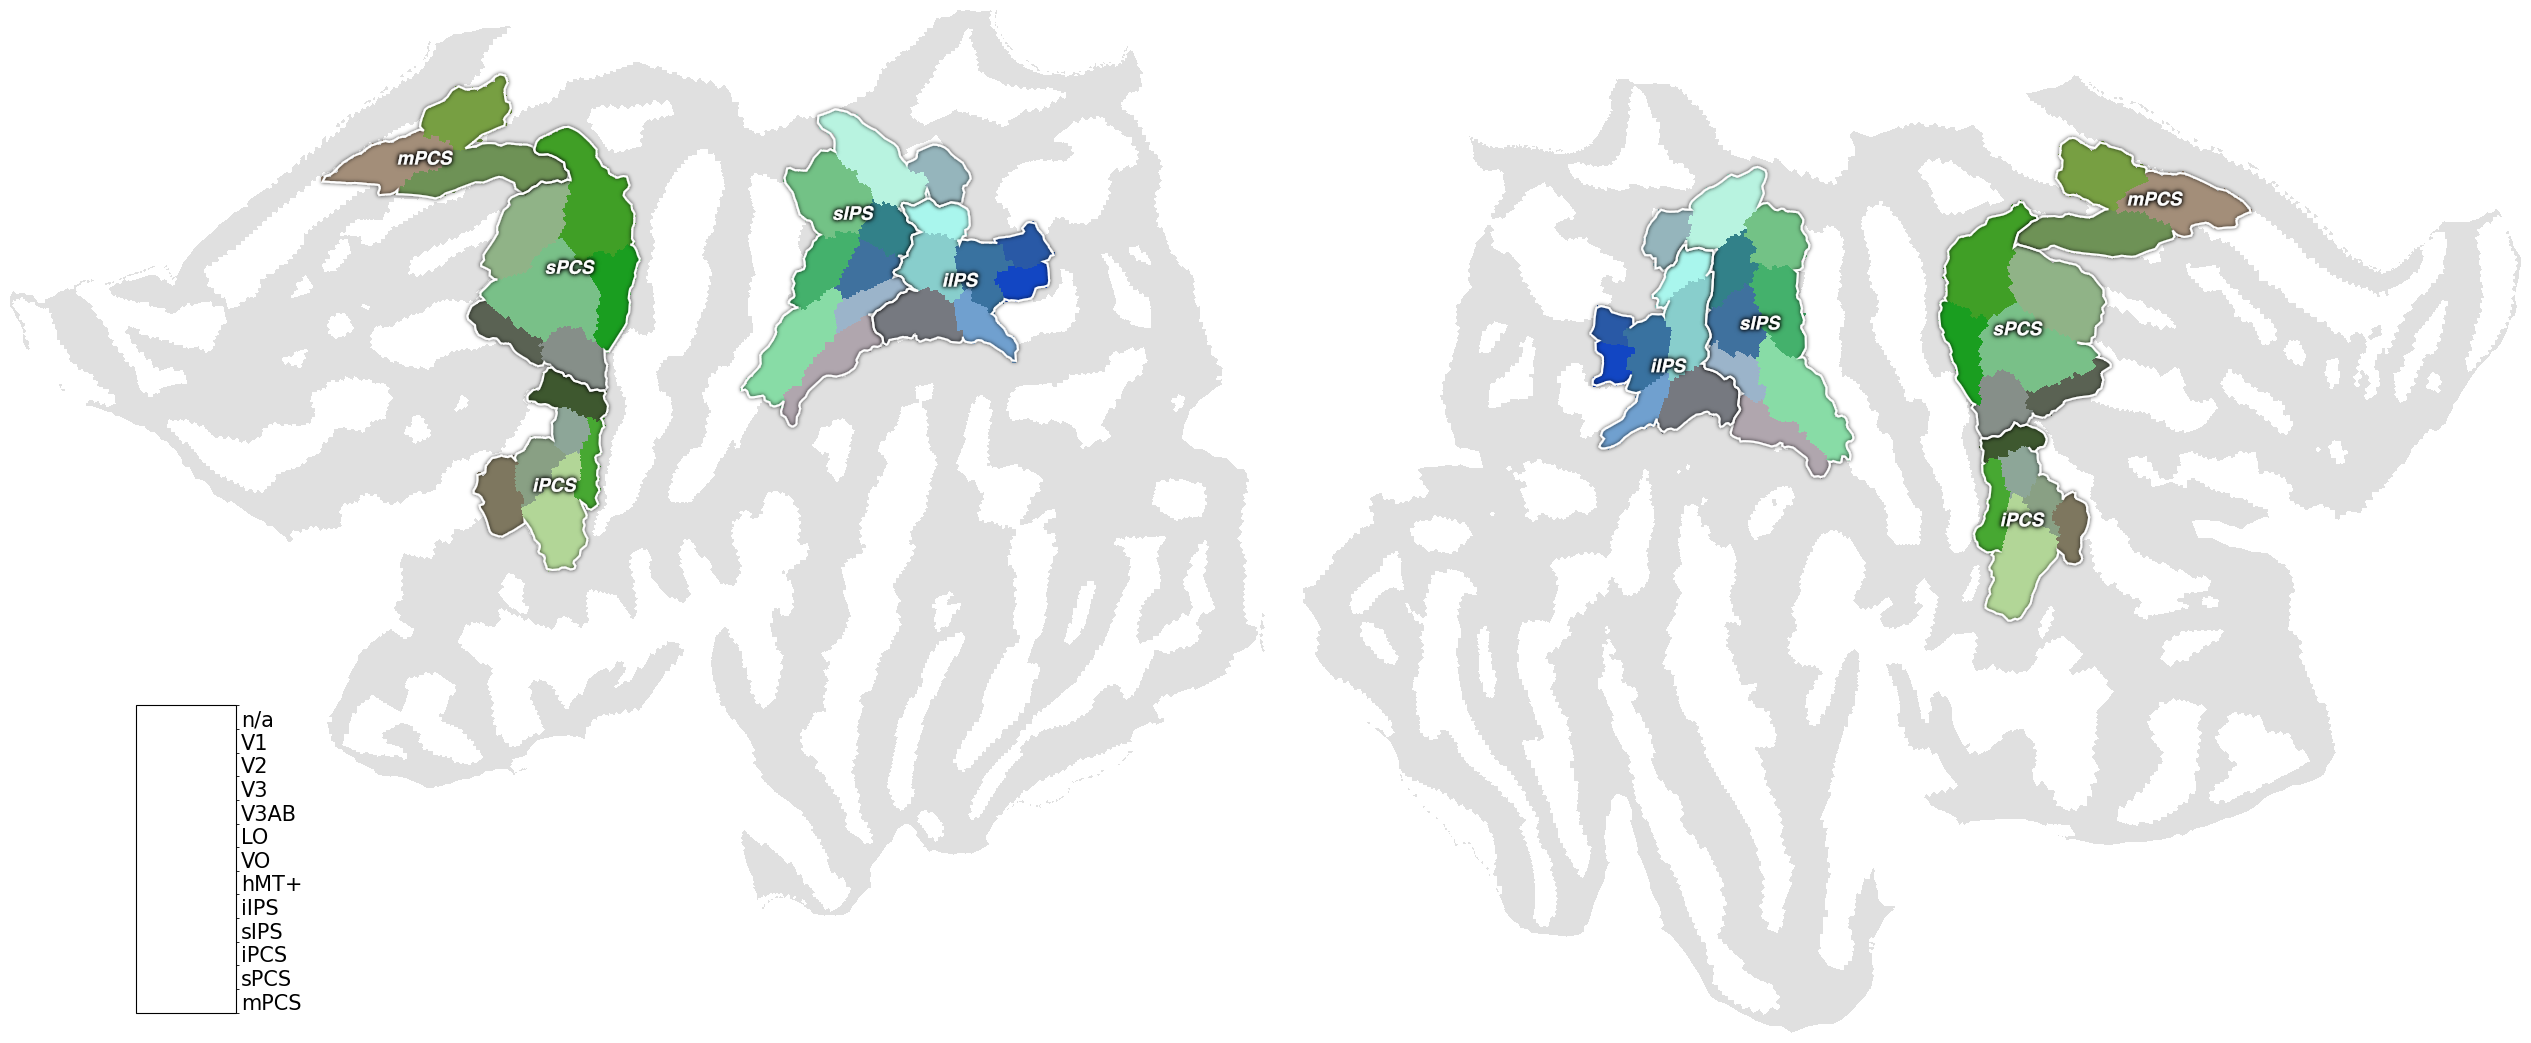

In [23]:
# Choos wich mask to apply
# rois_mask = eye_mvt_mask
rois_mask = parietal_frontal_mask
# rois_mask = all_rois_mask

# Alpha mat
alpha_mat = mmp_rois_data*0+rois_opacity
alpha_mat[mmp_rois_data==0]=0
rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# Pycortex settings
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': mmp_rois_data, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 255,
              'cmap_steps': 255,
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

# Plot
volume_roi = draw_cortex(**param_rois)
# plt.close()

In [24]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois'),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25004/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25004


In [25]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

# #All rois
# inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
# im1 = handle.getImage('{}/inflated_mmp.png'.format(inflated_dir),size = (3000, 3000))

# # Eye mvt network
# inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
# im1 = handle.getImage('{}/inflated_mmp_eye_mvt_network.png'.format(inflated_dir),size = (3000, 3000))

# Eye mvt network
inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
im1 = handle.getImage('{}/inflated_mmp_frontal_parietal.png'.format(inflated_dir),size = (3000, 3000))

## 170k brain

In [19]:
colormap_name = 'HCP_MMP1'
rois_opacity = 0

# load rois mask
rois_dict_mmp_group = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
rois_dict_mmp = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp', surf_size='59k')

all_rois_mask = np.logical_or.reduce([rois_dict_mmp.get(roi, False) for roi in rois_dict_mmp.keys()])
rois_mask = all_rois_mask

# Alpha mat
alpha_mat = mmp_rois_data*0+rois_opacity
alpha_mat[mmp_rois_data==0]=0
rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# Pycortex settings
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': mmp_rois_data, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 180,
              'cmap_steps': 180,
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': False,
              'with_labels': True,
              'roi_name': roi_name}

# Plot
volume_roi = draw_cortex(**param_rois)
plt.close()


Stopping server


In [20]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi,
                           recache=True,
                           port=port_num,
                           overlays_visible=(),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25003/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25003


In [21]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
im1 = handle.getImage('{}/inflated_170k.png'.format(inflated_dir),size = (3000, 3000))

Stopping server


## ROIs

In [25]:
subject = 'sub-11'
format_ = '170k'
pycortex_subject = 'sub-170k'
save_svg = False

rois_dir = "{}/{}/derivatives/pp_data/{}/{}/rois".format(main_dir, project_dir, subject,format_)
roi_fn = '{}/{}_rois.dtseries.nii'.format(rois_dir, subject)
results = load_surface_pycortex(brain_fn=roi_fn)
roi_mat = results['data_concat']

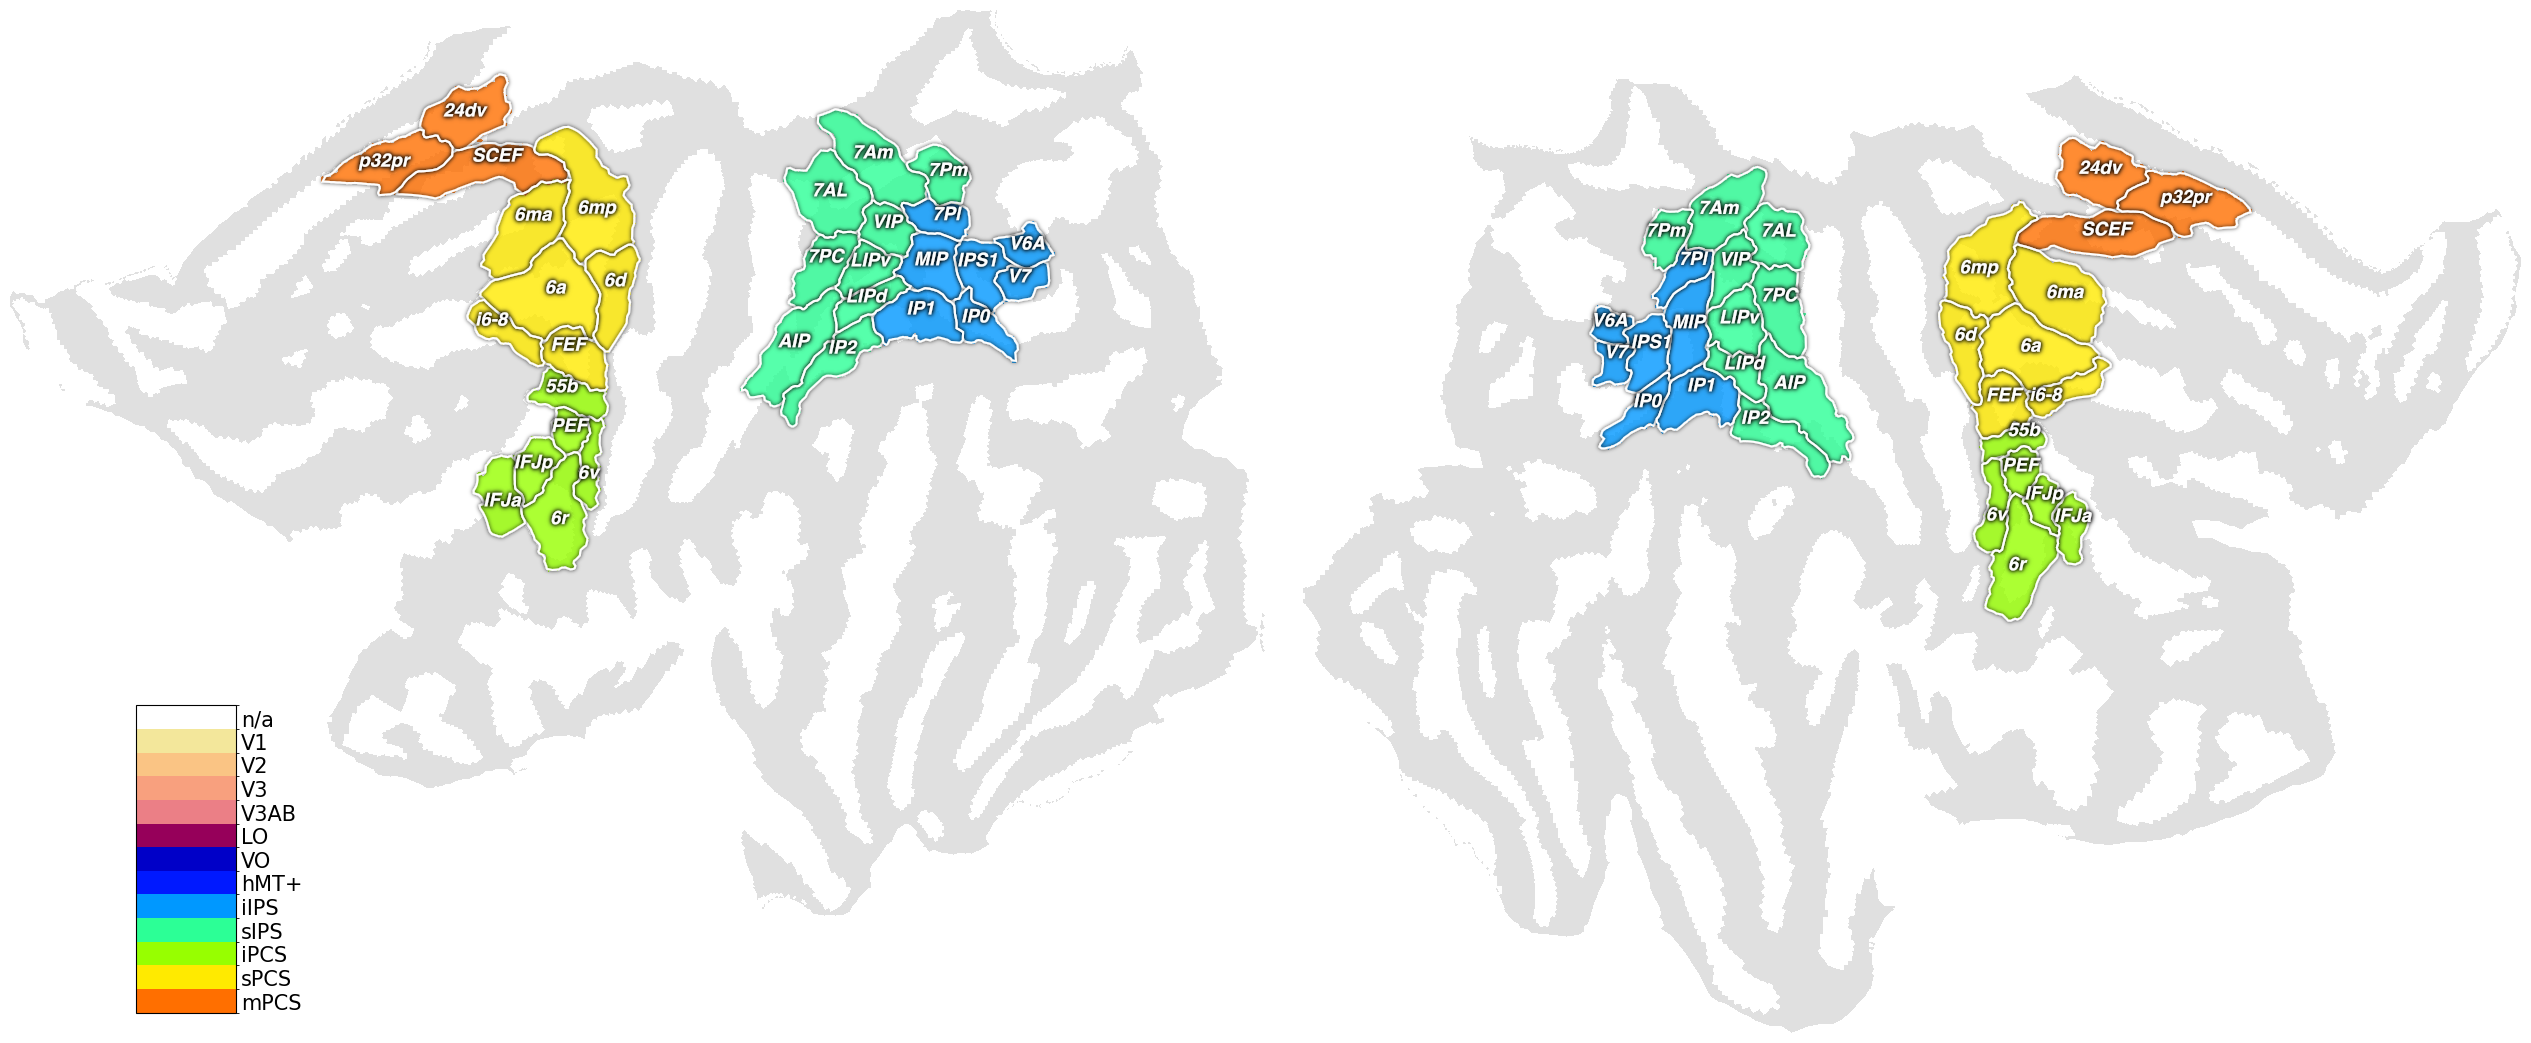

In [38]:
colormap_name = 'rois_colors'
rois_opacity = 0.8

rois_dic = get_rois(subject=subject, return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']
parietal_frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']

rois_mask = parietal_frontal_mask

# masks = {'frontal_mask':frontal_mask, 'parietal_mask':parietal_mask}
masks = {'parietal_frontal_mask':parietal_frontal_mask}

alpha_mat = roi_mat*0+rois_opacity
alpha_mat[roi_mat==0]=0

rois_mask = rois_mask.reshape(1,-1)
alpha_mat[~rois_mask] = 0

# rois_mask = rois_mask.reshape(1,-1)
# alpha_mat[~rois_mask] = 0
roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': roi_mat, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 12,
              'cmap_steps': len(colormap_dict),
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': save_svg,
              'with_labels': True,
              'roi_name': roi_name}

volume_roi = draw_cortex(**param_rois)

# Save results
flatmaps_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_flatmaps'
plt.savefig('{}/rois_flat.pdf'.format(flatmaps_dir))

In [30]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois'),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25006/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25006


In [31]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
im1 = handle.getImage('{}/inflated_170k_rois.png'.format(inflated_dir),size = (3000, 3000))

Stopping server


# GLM results

In [26]:
# Settings
subject = 'sub-11'
pycortex_subject = 'sub-170k'
format_ = '170k'
extension = 'dtseries.nii'
prf_task_name = analysis_info['prf_task_name']
alpha_range = analysis_info["alpha_range"]
group_tasks = analysis_info['task_intertask']
flatmaps_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_flatmaps'

suffix = 'Sac_Pur'
sac_task = 'SacLoc'
pur_task = 'PurLoc'


## Load data

In [28]:
# Maps settings
all_idx, pur_idx, sac_idx, pur_sac_idx, prf_idx, prf_pur_idx, prf_sac_idx, \
        prf_pur_sac_idx = 0,1,2,3,4,5,6,7

slope_idx, intercept_idx, rvalue_idx, pvalue_idx, stderr_idx, \
    trs_idx, corr_pvalue_5pt_idx, corr_pvalue_1pt_idx = 0, 1, 2, 3, 4, 5, 6, 7

# Set pycortex db and colormaps
cortex_dir = "{}/{}/derivatives/pp_data/cortex".format(main_dir, project_dir)
set_pycortex_config_file(cortex_dir)

# Define/create colormap
colormap_name = 'viridis'
colormap_dict = {'n/a': (255, 255, 255),
                 'Pursuit':  (227, 119, 194),
                 'Saccade': (140, 86, 75),
                 'Pursuit_and_Saccade': (148, 103, 189),
                 'Vision': (214, 39, 40),
                 'Vision_and_Pursuit': (44, 160, 44), 
                 'Vision_and_Saccade': (255, 127, 14),
                 'Vision_and_Pursuit_and_Saccade': (31, 119, 180)}
# create_colormap(cortex_dir=cortex_dir, 
#                 colormap_name=colormap_name, 
#                 colormap_dict=colormap_dict)



# Define directories and fn
intertask_dir = "{}/{}/derivatives/pp_data/{}/{}/intertask".format(
    main_dir, project_dir, subject,format_)
prf_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/prf/prf_derivatives".format(
    main_dir, project_dir, subject,format_)
glm_stats_dir = "{}/{}/derivatives/pp_data/{}/{}/glm/glm_derivatives".format(
    main_dir, project_dir,  subject,format_)

stats_avg_fn = '{}/{}_intertask_{}.dtseries.nii'.format(
    intertask_dir, subject, suffix)
prf_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_prf-stats_loo-median.dtseries.nii'.format(
    prf_stats_dir, subject, prf_task_name)
sac_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, sac_task)
pur_stats_avg_fn = '{}/{}_task-{}_fmriprep_dct_avg_glm-stats_loo-median.dtseries.nii'.format(
    glm_stats_dir, subject, pur_task)

#  Load data
results_stats = load_surface_pycortex(brain_fn=stats_avg_fn)
intertask_mat = results_stats['data_concat']

results_prf = load_surface_pycortex(brain_fn=prf_stats_avg_fn)
prf_mat = results_prf['data_concat']

results_sac = load_surface_pycortex(brain_fn=sac_stats_avg_fn)
sac_mat = results_sac['data_concat']

results_pur = load_surface_pycortex(brain_fn=pur_stats_avg_fn)
pur_mat = results_pur['data_concat']

if subject == 'sub-170k': save_svg = save_svg
else: save_svg = False


# Compute R2 from R
prf_mat[rvalue_idx,:] =  prf_mat[rvalue_idx,:]**2
sac_mat[rvalue_idx,:] = sac_mat[rvalue_idx,:]**2
pur_mat[rvalue_idx,:] = pur_mat[rvalue_idx,:]**2

# threshold data
# pRF
prf_mat_corrected = copy.copy(prf_mat)
prf_mat_corrected_th = prf_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = prf_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = prf_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
prf_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# SacLoc        
sac_mat_corrected = copy.copy(sac_mat)
sac_mat_corrected_th = sac_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = sac_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = sac_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
sac_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

# PurLoc        
pur_mat_corrected = copy.copy(pur_mat)
pur_mat_corrected_th = pur_mat_corrected
if analysis_info['stats_th'] == 0.05: stats_th_down = pur_mat_corrected_th[corr_pvalue_5pt_idx,...] <= 0.05
elif analysis_info['stats_th'] == 0.01: stats_th_down = pur_mat_corrected_th[corr_pvalue_1pt_idx,...] <= 0.01
pur_mat_corrected[rvalue_idx, stats_th_down==False]=0 # put this to zero to not plot it

## Compute the R2

In [29]:
#  Creat R2 for the all flatmap
rsq_all = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 1: rsq_all[vert] = pur_mat_corrected[rvalue_idx,vert]

    elif categorie == 2: rsq_all[vert] = sac_mat_corrected[rvalue_idx,vert]

    elif categorie == 3: rsq_all[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 4: rsq_all[vert] = prf_mat_corrected[rvalue_idx,vert]

    elif categorie == 5: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     pur_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 6: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                     sac_mat_corrected[rvalue_idx,vert]],
                                                    axis=0)

    elif categorie == 7: rsq_all[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                      sac_mat_corrected[rvalue_idx,vert], 
                                                      pur_mat_corrected[rvalue_idx,vert]], 
                                                    axis=0)

#  Creat R2 for the pur_sac flatmap       
rsq_pur_sac = np.zeros((intertask_mat[pur_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[pur_sac_idx,...]):
    if categorie == 3: rsq_pur_sac[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur flatmap               
rsq_prf_pur = np.zeros((intertask_mat[prf_pur_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_pur_idx,...]):
    if categorie == 5: rsq_prf_pur[vert] = np.nanmedian([pur_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_sac flatmap               
rsq_prf_sac = np.zeros((intertask_mat[prf_sac_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[prf_sac_idx,...]):
    if categorie == 6: rsq_prf_sac[vert] = np.nanmedian([prf_mat_corrected[rvalue_idx,vert], 
                                                       sac_mat_corrected[rvalue_idx,vert]], 
                                                      axis=0)

#  Creat R2 for the prf_pur_sac flatmap               
rsq_prf_pur_sac = np.zeros((intertask_mat[all_idx,...].shape))
for vert, categorie in enumerate(intertask_mat[all_idx,...]):
    if categorie == 7: rsq_prf_pur_sac[vert] = np.nanmean([prf_mat[rvalue_idx,vert], 
                                                           sac_mat_corrected[rvalue_idx,vert], 
                                                           pur_mat_corrected[rvalue_idx,vert]], 
                                                          axis=0)

## Create the flatmaps

In [30]:
maps_names = []      

# get roi mask 
rois_dic = get_rois(subject='sub-12', return_concat_hemis=True, return_hemi=None, rois=None, mask=True, atlas_name='mmp_group', surf_size='59k')
frontal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS']
parietal_mask = rois_dic['iIPS'] | rois_dic['sIPS']
frontal_parietal_mask = rois_dic['iPCS'] | rois_dic['sPCS'] | rois_dic['mPCS'] | rois_dic['iIPS'] | rois_dic['sIPS']

# masks = {'frontal_mask':frontal_mask}
# masks = {'parietal_mask':parietal_mask}
masks = {'frontal_parietal_mask':frontal_parietal_mask}

for mask in masks.keys():
    rois_mask = masks[mask]

    #  Creat the vision_and_pursuit_and_saccade flatmap
    alpha_prf_pur_sac = (rsq_prf_pur_sac - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_prf_pur_sac[alpha_prf_pur_sac>1]=1
    alpha_prf_pur_sac[~rois_mask] = 0


    intertask_data_prf_pur_sac = intertask_mat[prf_pur_sac_idx,...]
    alpha_prf_pur_sac[intertask_data_prf_pur_sac == 0] = 0
    param_vision_and_pursuit_and_saccade = {'data': rsq_prf_pur_sac, 
                                            'cmap': colormap_name, 
                                            'alpha': alpha_prf_pur_sac, 
                                            'vmin': 0, 
                                            'vmax': 0.4, 
#                                             'cbar': 'discrete_personalized', 
                                            'cmap_steps': len(colormap_dict), 
                                            'cmap_dict': colormap_dict,
                                            'cortex_type': 'VertexRGB', 
                                            'description': 'intertask map', 
                                            'curv_brightness': 1, 
                                            'curv_contrast': 0.25, 
                                            'add_roi': save_svg, 
                                            'cbar_label': '',  
                                            'with_labels': True}
    maps_names.append('vision_and_pursuit_and_saccade')
    
    #  Creat the pursuit flatmap
    rsq_pur = pur_mat_corrected[rvalue_idx, :]


    alpha_pur = (rsq_pur - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_pur[alpha_pur>1]=1
    alpha_pur[~rois_mask] = 0



    intertask_data_pur = intertask_mat[pur_idx,...]
    alpha_pur[intertask_data_pur == 0] = 0
    param_pursuit = {'data': rsq_pur, 
                     'cmap': colormap_name, 
                     'alpha': alpha_pur, 
                     'vmin': 0, 
                     'vmax': 0.4, 
#                      'cbar': 'discrete_personalized', 
                     'cmap_steps': len(colormap_dict),
                     'cmap_dict': colormap_dict,
                     'cortex_type': 'VertexRGB', 
                     'description': 'intertask map',
                     'curv_brightness': 1, 
                     'curv_contrast': 0.25, 
                     'add_roi': save_svg,
                     'cbar_label': '', 
                     'with_labels': True}
    maps_names.append('pursuit')

    #  Creat the saccade flatmap
    rsq_sac = sac_mat_corrected[rvalue_idx, :]
    alpha_sac = (rsq_sac - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_sac[alpha_sac>1]=1
    alpha_sac[~rois_mask] = 0


    intertask_data_sac = intertask_mat[sac_idx,...]
    alpha_sac[intertask_data_sac == 0] = 0
    param_saccade = {'data': rsq_sac, 
                     'cmap': colormap_name, 
                     'alpha': alpha_sac, 
                     'vmin': 0, 
                     'vmax': 0.4, 
#                      'cbar': 'discrete_personalized', 
                     'cmap_steps': len(colormap_dict),
                     'cmap_dict': colormap_dict,
                     'cortex_type': 'VertexRGB', 
                     'description': 'intertask map',
                     'curv_brightness': 1, 
                     'curv_contrast': 0.25, 
                     'add_roi': save_svg,
                     'cbar_label': '', 
                     'with_labels': True}
    maps_names.append('saccade')
    
    #  Creat the vision flatmap
    rsq_prf = prf_mat_corrected[rvalue_idx, :].astype(np.float64)
    alpha_prf = (rsq_prf - alpha_range[0])/(alpha_range[1]-alpha_range[0])
    alpha_prf[alpha_prf>1]=1
    alpha_prf[~rois_mask] = 0


    intertask_data_prf = intertask_mat[prf_idx,...]
    alpha_prf[intertask_data_prf == 0] = 0
    param_vision = {'data': rsq_prf, 
                    'cmap': colormap_name, 
                    'alpha': alpha_prf, 
                    'vmin': 0, 
                    'vmax': 0.4, 
#                     'cbar': 'discrete_personalized', 
                    'cmap_steps': len(colormap_dict),
                    'cmap_dict': colormap_dict,
                    'cortex_type': 'VertexRGB', 
                    'description': 'intertask map',
                    'curv_brightness': 1, 
                    'curv_contrast': 0.25, 
                    'add_roi': save_svg,
                    'cbar_label': '',
                    'with_labels': True}
    maps_names.append('vision')

    # draw flatmaps
    volumes = {}
    for maps_name in maps_names:

        # create flatmap
        roi_name = '{}'.format(maps_name)
        roi_param = {'subject': pycortex_subject, 'xfmname': None, 'roi_name': roi_name}
        print(roi_name)
        exec('param_{}.update(roi_param)'.format(maps_name))
        exec('volume_{maps_name} = draw_cortex(**param_{maps_name})'.format(maps_name = maps_name))
        # exec("plt.savefig('{}/{}_{}_{}_{}.pdf')".format(flatmaps_dir, subject, maps_name, suffix, mask))
        exec("plt.savefig('{}/{}_{}_{}_{}_all_borders.pdf')".format(flatmaps_dir, subject, maps_name, suffix, mask))
        plt.close()

vision_and_pursuit_and_saccade
Stopping server
pursuit
Stopping server
Stopping server
Stopping server
saccade
vision


## WebGl

In [33]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_vision_and_pursuit_and_saccade,
                           recache=True,
                           port=port_num,
                           overlays_visible=('rois',),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25007/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25007


In [34]:
# inflated
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0.5,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':1,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)
time.sleep(5)

inflated_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains'
im1 = handle.getImage('{}/visumotor.png'.format(inflated_dir),size = (3000, 3000))

# Inflated video

In [5]:
subject = 'sub-11'
format_ = 'fsnative'
pycortex_subject = subject
save_svg = False

rois_dir = "{}/{}/derivatives/pp_data/{}/{}/rois".format(main_dir, project_dir, subject,format_)
roi_L_fn = '{}/{}_hemi-L_rois.func.gii'.format(rois_dir, subject)
roi_R_fn = '{}/{}_hemi-R_rois.func.gii'.format(rois_dir, subject)
results = load_surface_pycortex(L_fn=roi_L_fn, R_fn=roi_R_fn)
roi_mat = results['data_concat']

In [6]:
colormap_name = 'rois_colors'
colormap_dict = {'n/a': (255, 255, 255),
                 'V1': (243, 231, 155),
                 'V2': (250, 196, 132),
                 'V3': (248, 160, 126),
                 'V3AB': (235, 127, 134),
                 'LO': (150, 0, 90), 
                 'VO': (0, 0, 200),
                 'hMT+': (0, 25, 255),
                 'iIPS': (0, 152, 255),
                 'sIPS': (44, 255, 150),
                 'iPCS': (151, 255, 0),
                 'sPCS': (255, 234, 0),
                 'mPCS': (255, 111, 0)}

In [7]:
rois_opacity = 0

alpha_mat = roi_mat*0+rois_opacity
alpha_mat[roi_mat==0]=0

roi_name = 'brain_170k'
param_rois = {'subject': pycortex_subject,
              'data': roi_mat, 
              'cmap': colormap_name,
              'alpha': alpha_mat,
              'cbar': 'discrete_personalized', 
              'vmin': 0,
              'vmax': 12,
              'cmap_steps': len(colormap_dict),
              'cmap_dict': colormap_dict,
              'cortex_type': 'VertexRGB',
              'description': 'Gaussian pRF ROIs',
              'curv_brightness': 1, 
              'curv_contrast': 0.25,
              'add_roi': save_svg,
              'with_labels': True,
              'roi_name': roi_name}

volume_roi = draw_cortex(**param_rois)
plt.close()

In [8]:
port_num = port_num + 1

# Remome overlays_visible=('sulci','roi'), to have borders 
print("Go to (in 5 s...): http://localhost:{}/".format(port_num))
handle = cortex.webgl.show(data=volume_roi,
                           recache=True,
                           port=port_num,
                           overlays_visible=(),
                           labels_visible=()
                          )

Go to (in 5 s...): http://localhost:25001/
Generating new ctm file...
wm
wm
inflated
inflated
Started server on port 25001


In [9]:
# Initial view
inflated_general = {'camera.azimuth':241,
                    'camera.altitude':60,
                    'camera.radius':430,
                    'surface.{subject}.unfold':0,
                    'surface.{subject}.pivot':46,
                    'surface.{subject}.left':True,
                    'surface.{subject}.right':True,
                    'surface.{subject}.depth':0.5,
                    'surface.{subject}.specularity':0,
                    'surface.{subject}.layers':4,
                    'surface.{subject}.dither':False,
                    'surface.{subject}.colorbar':False,
                    'surface.{subject}.sampler':'nearest',
                    'surface.{subject}.curvature.brightness':0.25,
                    'surface.{subject}.curvature.contrast':0.25,
                    'surface.{subject}.curvature.smoothness':1}
handle._set_view(**inflated_general)

In [12]:
# Create frames
unvold_frames_dir = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/unfold_frames'
unfolds = np.linspace(0,0.5,50)
for n_unfold, unfold in enumerate(unfolds):  
    inflated_general['surface.{subject}.unfold'] = unfold
    handle._set_view(**inflated_general)
    im1 = handle.getImage('{}/{}_inflation.png'.format(unvold_frames_dir,n_unfold),size = (3000, 3000))


In [13]:
# Create giff
num_images = unfolds.shape[0]

# Liste pour stocker les images
images = []

# Charger chaque image
for n_unfold in range(num_images):
    image_path = os.path.join(unvold_frames_dir, "{}_inflation.png".format(n_unfold))
    img = Image.open(image_path).convert("RGBA")

    # Créer un fond blanc (ou autre couleur) pour éviter l'effet de superposition
    background = Image.new("RGBA", img.size, (255, 255, 255, 255))  # blanc opaque
    background.paste(img, (0, 0), img)
    images.append(background)

# Convertir en mode "P" pour le GIF (optionnel, mais courant pour optimiser)
images = [im.convert("P", palette=Image.ADAPTIVE) for im in images]

# Créer le GIF
output_gif_path = '/Users/uriel/Documents/INT/Presentation/2025/VSS_2025/talk/Material/material/figures/pycortex_brains/fsnative_inflation_video.gif'
images[0].save(output_gif_path, save_all=True, append_images=images[1:], optimize=False, duration=50, loop=0)

print("GIF créé avec succès !")

GIF créé avec succès !
